Mounted at /content/drive
Validation Metrics:
Accuracy: 0.9787878787878788
Precision: 0.9855670103092784
Recall: 0.9715447154471545
F1 Score: 0.9785056294779939
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       996
           1       0.99      0.97      0.98       984

    accuracy                           0.98      1980
   macro avg       0.98      0.98      0.98      1980
weighted avg       0.98      0.98      0.98      1980


Testing Metrics:
Accuracy: 0.9765656565656565
Precision: 0.9888793840889649
Recall: 0.9625312239800167
F1 Score: 0.9755274261603376
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1274
           1       0.99      0.96      0.98      1201

    accuracy                           0.98      2475
   macro avg       0.98      0.98      0.98      2475
weighted avg       0.98      0.98      0.98      2475



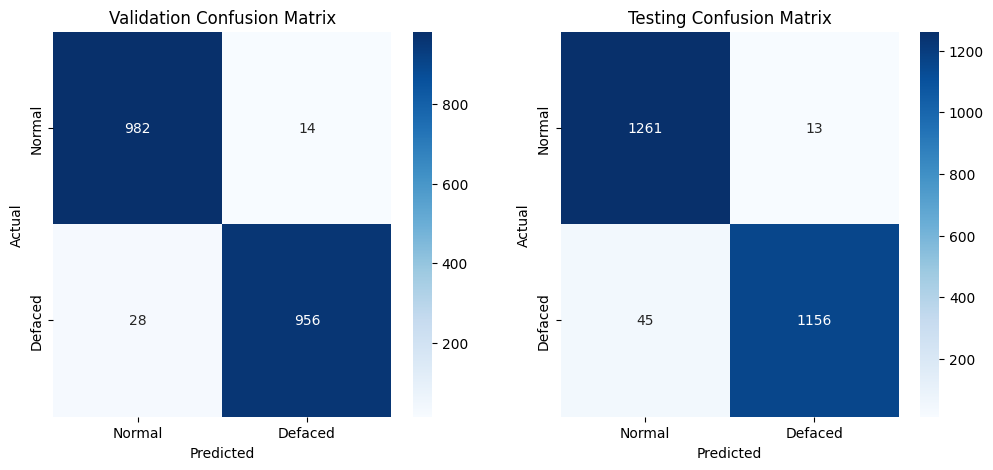

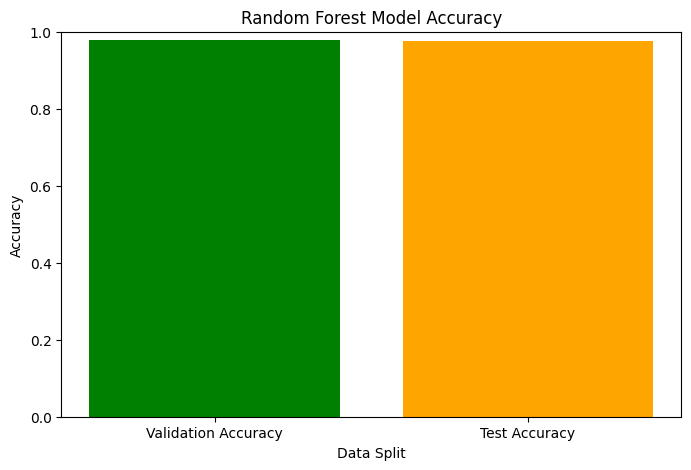

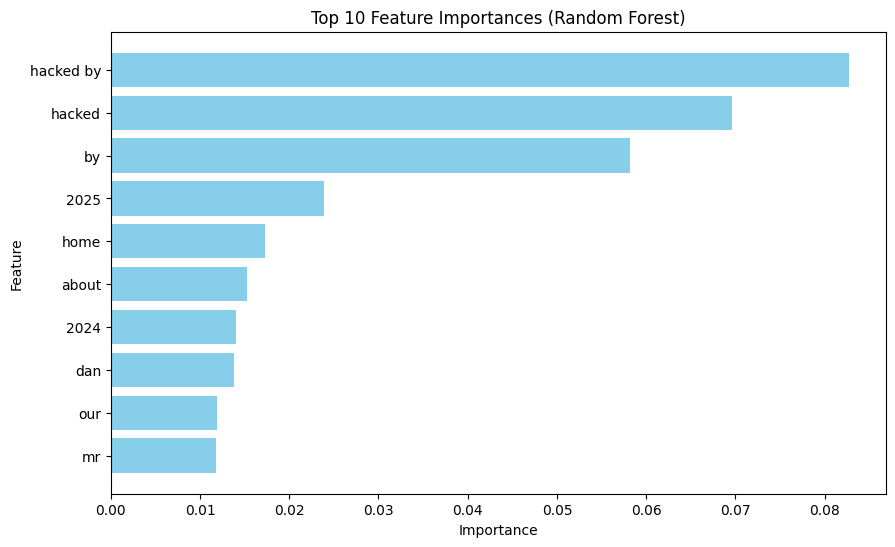

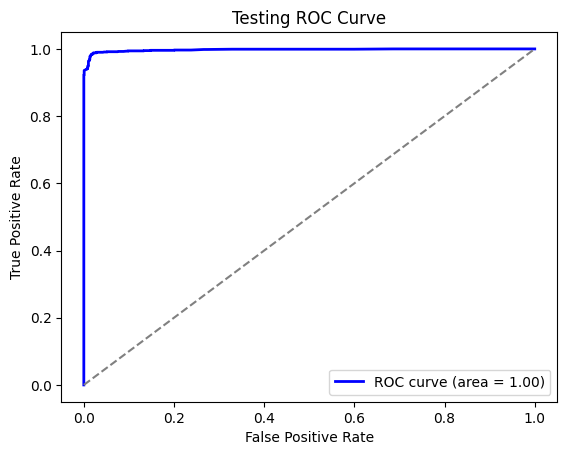

Pelatihan Berhasil Disimpan.
False Positive and False Negative filenames saved to CSV files.

=== Resource Usage & Performance Log ===


,Model,Training Time (s),Inference Time (s),CPU Usage (%),RAM Usage (MB),Model Size (MB),Accuracy,Precision,Recall,F1 Score
0,RandomForest,12.98,0.13,3.0,0.01,7.28,0.9766,0.9889,0.9625,0.9755


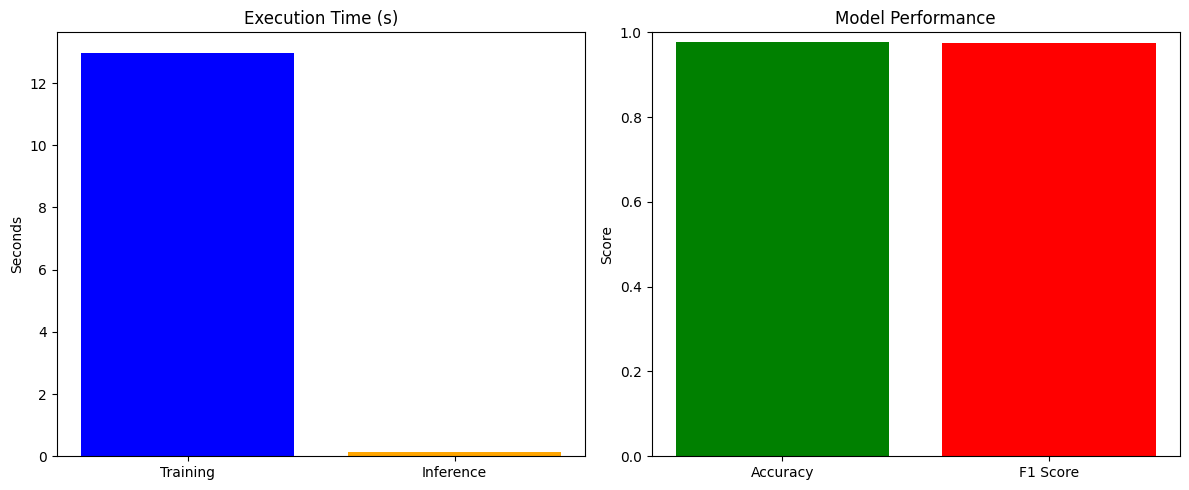

In [ ]:
#Teks Only

import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time
import joblib
import psutil
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_curve, auc
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Path to dataset
dataset_path = "/content/drive/My Drive/Colab Notebooks/3. Data Pre Processing/Dataset After Preprocessing/5. Plain Text Only + Fitur PFA, Ablation dan PFI.csv"

# Simpan model ke file .pkl
model_path = "/content/drive/My Drive/Colab Notebooks/5. Output/1. Random Forest/Text Only/web_defacement_model.pkl"
vectorizer_path = "/content/drive/My Drive/Colab Notebooks/5. Output/1. Random Forest/Text Only/vectorizer.pkl"

# Load dataset
df = pd.read_csv(dataset_path)
df = df.dropna(subset=["plain_text_only"])

# Ambil teks dan label
filenames = df["filename"].tolist()
texts = df["plain_text_only"].tolist()
labels = df["label"].tolist()

# Split dataset
train_texts, test_texts, train_labels, test_labels, train_filenames, test_filenames = train_test_split(
    texts, labels, filenames, test_size=0.2, random_state=42)
train_texts, val_texts, train_labels, val_labels, train_filenames, val_filenames = train_test_split(
    train_texts, train_labels, train_filenames, test_size=0.2, random_state=42)

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train = vectorizer.fit_transform(train_texts).toarray()
X_val = vectorizer.transform(val_texts).toarray()
X_test = vectorizer.transform(test_texts).toarray()

# Train Random Forest Model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, train_labels)

# Evaluate on Validation Data
val_preds = rf_model.predict(X_val)
val_accuracy = accuracy_score(val_labels, val_preds)
val_precision = precision_score(val_labels, val_preds)
val_recall = recall_score(val_labels, val_preds)
val_f1 = f1_score(val_labels, val_preds)

print("Validation Metrics:")
print(f"Accuracy: {val_accuracy}")
print(f"Precision: {val_precision}")
print(f"Recall: {val_recall}")
print(f"F1 Score: {val_f1}")
print(classification_report(val_labels, val_preds))

# Evaluate on Testing Data
test_preds = rf_model.predict(X_test)
test_accuracy = accuracy_score(test_labels, test_preds)
test_precision = precision_score(test_labels, test_preds)
test_recall = recall_score(test_labels, test_preds)
test_f1 = f1_score(test_labels, test_preds)

print("\nTesting Metrics:")
print(f"Accuracy: {test_accuracy}")
print(f"Precision: {test_precision}")
print(f"Recall: {test_recall}")
print(f"F1 Score: {test_f1}")
print(classification_report(test_labels, test_preds))

# Plot Confusion Matrix
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(confusion_matrix(val_labels, val_preds), annot=True, cmap='Blues', fmt='d', xticklabels=['Normal', 'Defaced'], yticklabels=['Normal', 'Defaced'], ax=axes[0])
axes[0].set_title("Validation Confusion Matrix")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

sns.heatmap(confusion_matrix(test_labels, test_preds), annot=True, cmap='Blues', fmt='d', xticklabels=['Normal', 'Defaced'], yticklabels=['Normal', 'Defaced'], ax=axes[1])
axes[1].set_title("Testing Confusion Matrix")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")

plt.show()

# Plot Accuracy Comparison
plt.figure(figsize=(8, 5))
plt.bar(["Validation Accuracy", "Test Accuracy"], [val_accuracy, test_accuracy], color=["green", "orange"])
plt.ylim(0, 1)
plt.title("Random Forest Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Data Split")
plt.show()

# Feature Importance Visualization
feature_importances = rf_model.feature_importances_
top_features_indices = feature_importances.argsort()[-10:][::-1]
top_features = [vectorizer.get_feature_names_out()[i] for i in top_features_indices]
top_importances = feature_importances[top_features_indices]

plt.figure(figsize=(10, 6))
plt.barh(top_features, top_importances, color="skyblue")
plt.title("Top 10 Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.gca().invert_yaxis()
plt.show()

# Plot ROC Curve
if hasattr(rf_model, "predict_proba"):
    fpr, tpr, _ = roc_curve(test_labels, rf_model.predict_proba(X_test)[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Testing ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

# Save Model
joblib.dump(rf_model, model_path)
joblib.dump(vectorizer, vectorizer_path)

print("Pelatihan Berhasil Disimpan.")

# Identify False Positives and False Negatives
fp_indices = [i for i, (pred, true) in enumerate(zip(test_preds, test_labels)) if pred == 1 and true == 0]
fn_indices = [i for i, (pred, true) in enumerate(zip(test_preds, test_labels)) if pred == 0 and true == 1]

fp_filenames = [test_filenames[i] for i in fp_indices]
fn_filenames = [test_filenames[i] for i in fn_indices]

fp_df = pd.DataFrame({'filename': fp_filenames})
fn_df = pd.DataFrame({'filename': fn_filenames})

fp_df.to_csv('/content/drive/My Drive/Colab Notebooks/5. Output/1. Random Forest/Text Only/false_positives.csv', index=False)
fn_df.to_csv('/content/drive/My Drive/Colab Notebooks/5. Output/1. Random Forest/Text Only/false_negatives.csv', index=False)

print("False Positive and False Negative filenames saved to CSV files.")

# Komparasi Performance
def log_model_performance(model, X_train, y_train, X_test, y_test, model_name, save_path):
    # Mulai timer dan ambil info RAM/CPU awal
    start_time = time.time()
    process = psutil.Process(os.getpid())
    ram_before = process.memory_info().rss / (1024 * 1024)  # dalam MB
    cpu_before = psutil.cpu_percent(interval=1)

    # Training
    model.fit(X_train, y_train)

    training_time = time.time() - start_time
    ram_after_train = process.memory_info().rss / (1024 * 1024)

    # Simpan model ke file
    model_file = os.path.join(save_path, f"{model_name}_model.pkl")
    joblib.dump(model, model_file)
    model_size = os.path.getsize(model_file) / (1024 * 1024)

    # Inference
    start_infer = time.time()
    y_pred = model.predict(X_test)
    inference_time = time.time() - start_infer
    ram_after_infer = process.memory_info().rss / (1024 * 1024)

    # Evaluasi metrik
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Simpan hasil ke DataFrame
    log_dict = {
        "Model": model_name,
        "Training Time (s)": round(training_time, 2),
        "Inference Time (s)": round(inference_time, 2),
        "CPU Usage (%)": cpu_before,
        "RAM Usage (MB)": round(ram_after_train - ram_before, 2),
        "Model Size (MB)": round(model_size, 2),
        "Accuracy": round(acc, 4),
        "Precision": round(prec, 4),
        "Recall": round(rec, 4),
        "F1 Score": round(f1, 4)
    }

    return pd.DataFrame([log_dict])


# === Fungsi untuk visualisasi waktu dan akurasi ===
def plot_resource_and_accuracy(log_df):
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    # Waktu eksekusi
    ax[0].bar(["Training", "Inference"],
              [log_df["Training Time (s)"].values[0], log_df["Inference Time (s)"].values[0]],
              color=["blue", "orange"])
    ax[0].set_title("Execution Time (s)")
    ax[0].set_ylabel("Seconds")

    # Akurasi
    ax[1].bar(["Accuracy", "F1 Score"],
              [log_df["Accuracy"].values[0], log_df["F1 Score"].values[0]],
              color=["green", "red"])
    ax[1].set_ylim(0, 1)
    ax[1].set_title("Model Performance")
    ax[1].set_ylabel("Score")

    plt.tight_layout()
    plt.show()

# Logging resource usage dan performa
save_log_path = "/content/drive/My Drive/Colab Notebooks/5. Output/1. Random Forest/Text Only"
os.makedirs(save_log_path, exist_ok=True)

log_df = log_model_performance(
    model=RandomForestClassifier(n_estimators=100, random_state=42),
    X_train=X_train,
    y_train=train_labels,
    X_test=X_test,
    y_test=test_labels,
    model_name="RandomForest",
    save_path=save_log_path
)

# Tampilkan log performa model
print("\n=== Resource Usage & Performance Log ===")
display(log_df)  # jika pakai Google Colab / Jupyter

# Simpan log ke file
log_df.to_csv(os.path.join(save_log_path, "resource_log.csv"), index=False)

# Visualisasi log
plot_resource_and_accuracy(log_df)

Mounted at /content/drive

Validation Metrics:
Accuracy: 0.9919, Precision: 0.9980, Recall: 0.9859, F1 Score: 0.9919
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       990
           1       1.00      0.99      0.99       990

    accuracy                           0.99      1980
   macro avg       0.99      0.99      0.99      1980
weighted avg       0.99      0.99      0.99      1980


Testing Metrics:
Accuracy: 0.9891, Precision: 0.9984, Recall: 0.9798, F1 Score: 0.9890
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1237
           1       1.00      0.98      0.99      1238

    accuracy                           0.99      2475
   macro avg       0.99      0.99      0.99      2475
weighted avg       0.99      0.99      0.99      2475



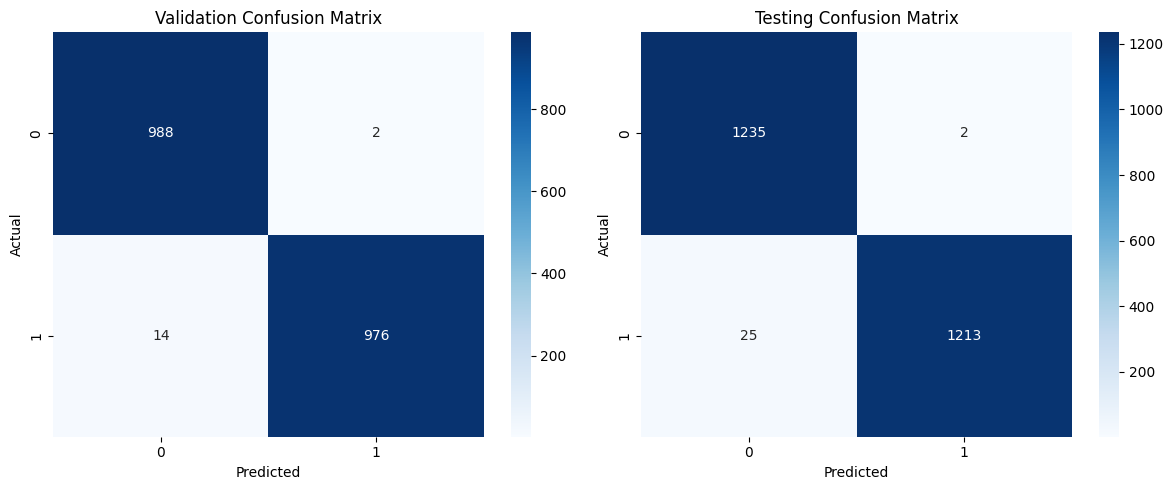

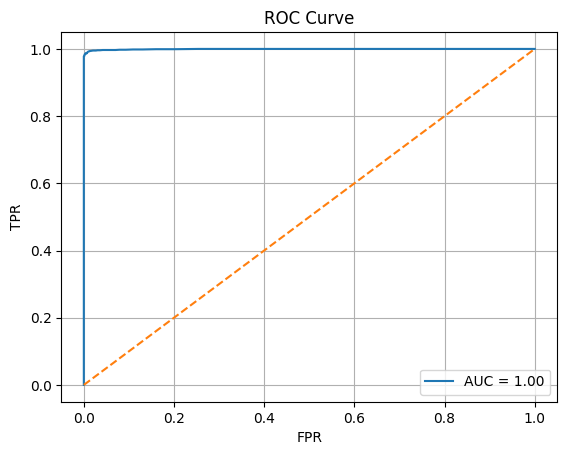

✅ False Positives & Negatives saved.


,Model,Training Time (s),Inference Time (s),CPU Usage (%),RAM Usage (MB),Model Size (MB),Accuracy,Precision,Recall,F1 Score
0,Hybrid_RF_Text+Feature,6.92,0.12,3.0,16.04,5.61,0.9891,0.9984,0.9798,0.989


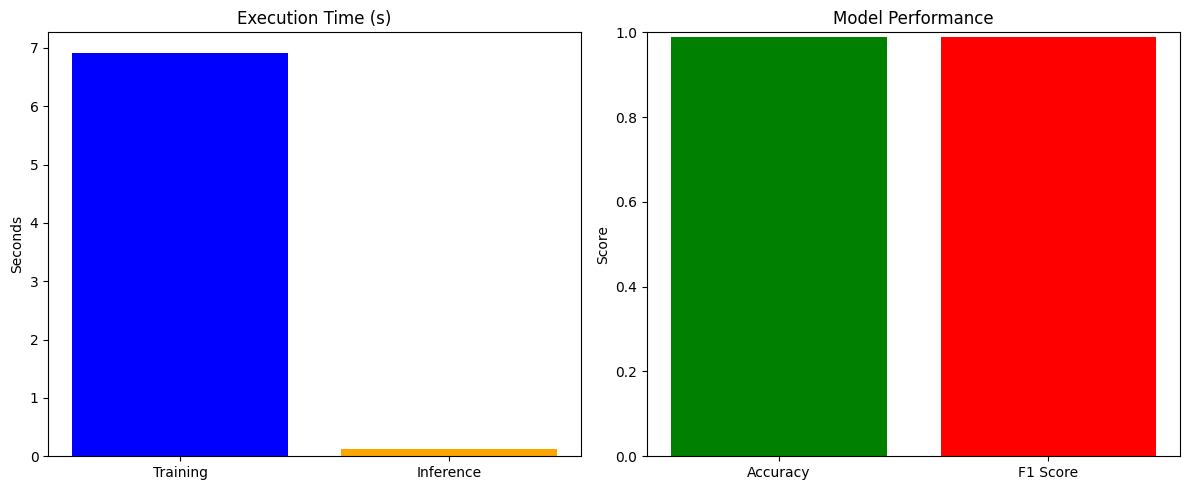

In [1]:
#Teks Only dan Fitur (SETELAH LAPORAN DIBUAT, KITA COBA EKSPLOR TAMBAHAN)

# =============================== [1] Install & Import ===============================
import os, time, joblib, psutil, hashlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tracemalloc
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_curve, auc
from scipy.sparse import hstack, csr_matrix
from google.colab import drive

# =============================== [2] Setup Path & Load ===============================
drive.mount('/content/drive')

dataset_path = "/content/drive/My Drive/Colab Notebooks/3. Data Pre Processing/Dataset After Preprocessing/5. Plain Text Only + Fitur PFA, Ablation dan PFI.csv"
model_path = "/content/drive/My Drive/Colab Notebooks/5. Output/1. Random Forest/Text Only + Fitur/web_defacement_model.pkl"
save_log_path = "/content/drive/My Drive/Colab Notebooks/5. Output/1. Random Forest/Text Only + Fitur"
os.makedirs(save_log_path, exist_ok=True)

df = pd.read_csv(dataset_path).dropna(subset=["plain_text_only"])

# =============================== [3] Preprocessing ===============================
text_col = "plain_text_only"
label_col = "label"
selected_features = [
    'total_tag','found_keywords', 'total_found_keywords', 'alert_keywords_combo','external_links',
    'js_autoplay_audio','img_tags','css_entropy','html_comment_count',
    'dom_max_depth','visual_density'
]

texts = df[text_col].astype(str).tolist()
labels = df[label_col].astype(int).tolist()
filenames = df["filename"].tolist()
X_feat = df[selected_features].fillna(0).values

vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_text = vectorizer.fit_transform(texts)
X_combined = hstack([X_text, csr_matrix(X_feat)])

# =============================== [4] Split ===============================
X_trainval, X_test, y_trainval, y_test, filenames_trainval, filenames_test = train_test_split(
    X_combined, labels, filenames, test_size=0.2, stratify=labels, random_state=42
)
X_train, X_val, y_train, y_val, filenames_train, filenames_val = train_test_split(
    X_trainval, y_trainval, filenames_trainval, test_size=0.2, stratify=y_trainval, random_state=42
)

# =============================== [5] Train + Evaluate + Log ===============================
process = psutil.Process(os.getpid())
cpu_before = psutil.cpu_percent(interval=1)

# Start tracking memory
tracemalloc.start()

start_time = time.time()
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
training_time = time.time() - start_time
current, peak = tracemalloc.get_traced_memory()
tracemalloc.stop()

ram_peak_mb = peak / (1024 * 1024)

joblib.dump(rf_model, model_path)
joblib.dump(vectorizer, os.path.join(save_log_path, "vectorizer.pkl"))
model_size = os.path.getsize(model_path) / (1024 * 1024)

# Inference time
start_infer = time.time()
y_pred_test = rf_model.predict(X_test)
inference_time = time.time() - start_infer

# =============================== [6] Evaluation ===============================
def evaluate(name, X, y_true):
    y_pred = rf_model.predict(X)
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print(f"\n{name} Metrics:")
    print(f"Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1 Score: {f1:.4f}")
    print(classification_report(y_true, y_pred))
    return acc, prec, rec, f1, y_pred

val_acc, val_prec, val_rec, val_f1, val_preds = evaluate("Validation", X_val, y_val)
test_acc, test_prec, test_rec, test_f1, test_preds = evaluate("Testing", X_test, y_test)

# =============================== [7] Visualizations ===============================
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(confusion_matrix(y_val, val_preds), annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title("Validation Confusion Matrix"); axes[0].set_xlabel("Predicted"); axes[0].set_ylabel("Actual")
sns.heatmap(confusion_matrix(y_test, test_preds), annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title("Testing Confusion Matrix"); axes[1].set_xlabel("Predicted"); axes[1].set_ylabel("Actual")
plt.tight_layout(); plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, rf_model.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0,1], [0,1], linestyle='--')
plt.title("ROC Curve"); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.legend(); plt.grid(True); plt.show()

# =============================== [8] Save FP & FN ===============================
fp_indices = [i for i, (p, t) in enumerate(zip(test_preds, y_test)) if p == 1 and t == 0]
fn_indices = [i for i, (p, t) in enumerate(zip(test_preds, y_test)) if p == 0 and t == 1]
fp_files = [filenames_test[i] for i in fp_indices]
fn_files = [filenames_test[i] for i in fn_indices]

pd.DataFrame({'filename': fp_files}).to_csv(f"{save_log_path}/false_positives.csv", index=False)
pd.DataFrame({'filename': fn_files}).to_csv(f"{save_log_path}/false_negatives.csv", index=False)

print("✅ False Positives & Negatives saved.")

# =============================== [9] Log Resource ===============================
log_df = pd.DataFrame([{
    "Model": "Hybrid_RF_Text+Feature",
    "Training Time (s)": round(training_time, 2),
    "Inference Time (s)": round(inference_time, 2),
    "CPU Usage (%)": cpu_before,
    "RAM Usage (MB)": round(ram_peak_mb, 2),
    "Model Size (MB)": round(model_size, 2),
    "Accuracy": round(test_acc, 4),
    "Precision": round(test_prec, 4),
    "Recall": round(test_rec, 4),
    "F1 Score": round(test_f1, 4)
}])

log_df.to_csv(os.path.join(save_log_path, "resource_log.csv"), index=False)

from IPython.display import display
display(log_df)

def plot_resource_and_accuracy(log_df):
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    ax[0].bar(["Training", "Inference"],
              [log_df["Training Time (s)"].values[0], log_df["Inference Time (s)"].values[0]], color=["blue", "orange"])
    ax[0].set_title("Execution Time (s)")
    ax[0].set_ylabel("Seconds")
    ax[1].bar(["Accuracy", "F1 Score"],
              [log_df["Accuracy"].values[0], log_df["F1 Score"].values[0]], color=["green", "red"])
    ax[1].set_ylim(0, 1)
    ax[1].set_title("Model Performance")
    ax[1].set_ylabel("Score")
    plt.tight_layout(); plt.show()

plot_resource_and_accuracy(log_df)
